# Home Credit Default Risk 예측
- ROC/AUC
- type, dtype
- unique, nunique
- value_counts
- apply
- get_dummies (동시 변환)
- label encoding
- groupby
- bar, KDE plot
- pairs plot
- scaling
- 랜덤 포레스트
- 컨퓨전 매트릭스

## 데이터

- 제공자 [Home Credit](http://www.homecredit.net/about-us.aspx)
- application_train/application_test: 메인 데이터로 `SK_ID_CURR`로 구분. `TARGET` 변수가 0이면 상환, 1이면 미상환 (여기서는 이 테이블만 사용한다)
- bureau: 다른 금융기관에서의 신용평가 데이터 (여러개의 평가가 있을 수 있다)
- bureau_balance: bureau의 월별 데이터 
- previous_application: 이전의 대출 신청 데이터 `SK_ID_PREV` 키로 구분
- POS_CASH_BALANCE: 이전의 POS 또는 현금 월별 거래 내역
- credit_card_balance: 카드 월별 사용 내역
- installments_payment: 지불 및 미지불 기록
- `HomeCredit_columns_description.csv` : 컬럼에 대한 설명문
- sample_submission.csv 경진대회 제출 양식

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## 평가척도: ROC AUC

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)


## Imports

- `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [0]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import os
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 다운로드

In [0]:
!curl -L https://bit.ly/34ttDj1 -o home_default_risk.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   157  100   157    0     0   1987      0 --:--:-- --:--:-- --:--:--  1987
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    721      0 --:--:--  0:00:01 --:--:--     0
100  688M  100  688M    0     0  39.8M      0  0:00:17  0:00:17 --:--:-- 45.4M


In [0]:
!ls

application_test.csv		    installments_payments.csv
application_train.csv		    log_reg_baseline.csv
bureau_balance.csv		    POS_CASH_balance.csv
bureau.csv			    previous_application.csv
credit_card_balance.csv		    random_forest_baseline.csv
defaul_risk.zip			    sample_data
HomeCredit_columns_description.csv  sample_submission.csv
home_default_risk.zip


In [0]:
!unzip defaul_risk.zip
# !unzip home_default_risk.zip

Archive:  defaul_risk.zip
replace installments_payments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: installments_payments.csv  n

  inflating: credit_card_balance.csv  n
n

  inflating: bureau.csv              
  inflating: POS_CASH_balance.csv    n
n
n

  inflating: sample_submission.csv   
  inflating: application_train.csv   n

  inflating: HomeCredit_columns_description.csv  
  inflating: previous_application.csv  n
n
n

  inflating: bureau_balance.csv      n
n

  inflating: application_test.csv    


In [0]:
# 훈련 데이터
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)

Training data shape:  (307511, 122)


In [0]:
app_train[:3]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# 테스트 데이터
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


`TARGET` 변수는 가지고 있지 않다

# EDA: Exploratory Data Analysis

- 데이터간 관계, 트렌드, 이상치, 패턴을 파악하는 분석을 말한다.
- 데이터에 숨어있는 의미를 찾는다.
- 향후 분석에 어떤 특성을 사용할지를 판단하는데 사용된다.

## 타겟 변수 분포

In [0]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

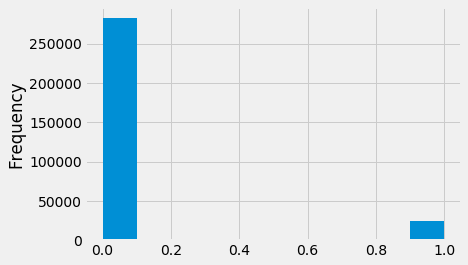

In [0]:
app_train['TARGET'].astype(int).plot.hist();

- [데이터의 불균형이있다](http://www.chioka.in/class-imbalance-problem/). 
- [가중치를 주는 방법](http://xgboost.readthedocs.io/en/latest/parameter.html) 

## 결측치 처리

In [0]:
def missing_values_table(df):
        # 결측치 전체
        mis_val = df.isnull().sum()
        
        # 퍼센트
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # 테이블로 표현
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # 컬럼 이름 변경
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # 정렬
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # 일부 결과 출력
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # 결과 리턴
        return mis_val_table_ren_columns

In [0]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


- 결측치를 채우는 것이 필요한 경우가 있다.(imputation이라고 함)
- 결측치를 채우지 않고 분석하는 방법도 있으며 XGBoost를 사용한다.[imputation를 사용하지 않는 xgboost](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). 
- 결측치가 많은 컬럼(특성)을 삭제하는 방법도 있다.

## 특성 타입

- 수치 타입 특성과, 객체 타입 특성을 구분한다. `int64` and `float64` ([discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` 특성은 문자열을 가르킨다. [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [0]:
# 컬럼의 데이터 타입의 종류를 본다
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [0]:
# 객체 타입 특성의 가짓수를 본다
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

##  카테고리 변수의 인코딩

- Label encoding: 카테고리별로 고유의 숫자를 배정하는 방법
![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)
 - 임의의 숫자 번호가 배정되며 이 숫자의 의미가 잘 못 인식될 수 있다. 카테고리 수가 2개일 때는 0/1 만 사용하므로 구분하는데 문제가 없다.
 - LabelEncoder를 사용한다.

- One-hot encoding: 카테고리 수만큼 컬럼을 만들고 한 컬럼만 1로 코딩

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)
 
 - get_dummies(df)를 사용한다.
 - OHE은 안전한 방법이다. 
 - 단점은 컬럼수가 늘어난다는 것인데 컬럼수가 너무 큰 경우는
[PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) 나 [차원축소](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/)를 수행하는 방법이 있다.


In [0]:
# 카테고리 수가 2 이하인 것을 먼저 수치 값으로 인코딩한다. (0/1)
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        # 2개 이하인 경우
        if len(list(app_train[col].unique())) <= 2:
            # 카테고리 변환 (학습: fit)
            le.fit(app_train[col])
            # 카테고리 변환 (수행: transform)
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [0]:
# 나머지 객체 타입 특성을 모두 원 핫 인코딩한다.
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


###  훈련 데이터와 테스트 데이터의 컬럼 일치 (Aligning)

- 훈련 데이터에 불필요하게 더 들어 있는 컬럼을 제거한다.
- 타겟 변수는 따로 저장해 둔다.

In [0]:
train_labels = app_train['TARGET']

# 두 데이터프레임에 공통으로 존재하는 컬럼만 남긴다
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# 타겟 변수를 다시 추가한다.
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


- 원핫인코딩으로 인해 차원수가 239로 크다. 필요하면 [차원축소](https://en.wikipedia.org/wiki/Dimensionality_reduction)를 수행한다.

## 이상치 탐지
- 먼저 기본 통계를 `describe`로 확인다.
- `DAYS_BIRTH` 가 음수인 것은 현재의 대출에 대한 상대값이기 때문이다.
- 이 값에 -1을 곱하고 연간 일수로 나누면 연단위 값으로 볼 수 있다.

In [0]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [0]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

- 최대 값이 1000년이나 된다. 오류가 있다.

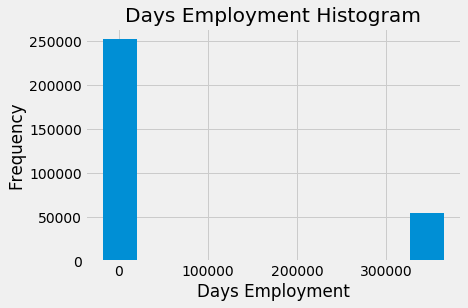

In [0]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

- 부도 경우 중에, 이상치의 비율을 확인한다.

In [0]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


- 이상치가 모두 동일한 값이다.
- 여기서는 nan으로 대체하고 이를 표시해 두겠다.

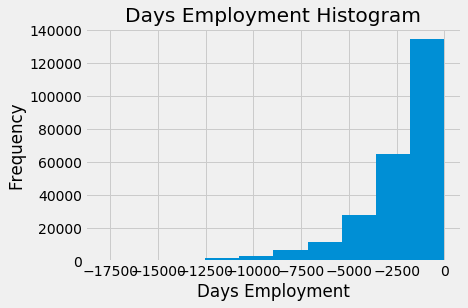

In [0]:
# 플래스 추가
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# nan으로 대체
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

- 같은 작업을 반드시 테스트 데이터에 대해서도 수행해야 한다.

In [0]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### 상관계수를 본다
- Pearson correlation을 `.corr`로 계산한다

In [0]:
# 목적 변수와의 상관관계
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

- 젊을수록 부도율이 높은 것을 알 수 있다.

### Effect of Age on Repayment

In [0]:
# 음수를 양수로 바꾸어 본다
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

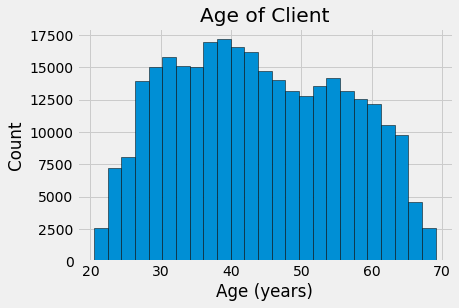

In [0]:
# 그림 스타일 지정
plt.style.use('fivethirtyeight')

# 연령 분포
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

- 나이와 타겟변수의 분포를 보기 위해서[kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) 플롯을 그린다.
[KDE](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/)는 가우시안 커널을 이용한 완만한 확률분포함수이다. 

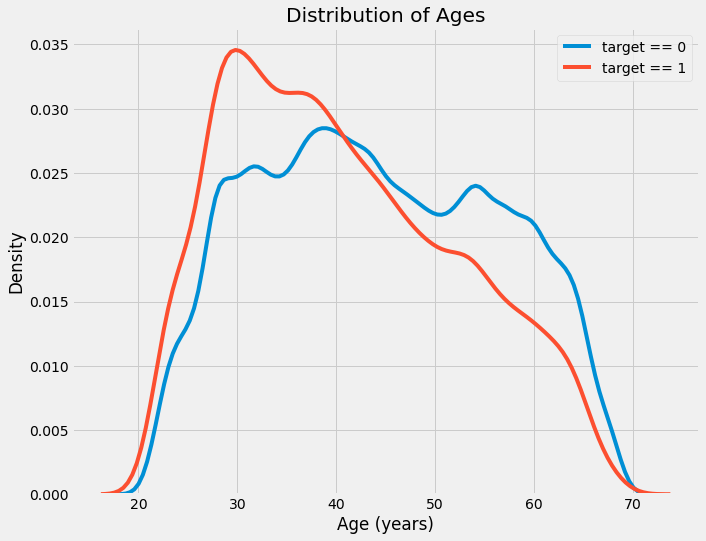

In [0]:
plt.figure(figsize = (10, 8))

# 정상 상환 플롯
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# 상환 부도 플롯
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

- 나이 구간을 5세로 나누어 부도율을 비교해보겠다.

In [0]:
# 별도의 데이터프레임 생서
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 구간 나누기 cut 사용
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [0]:
# 그룹별 평균
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


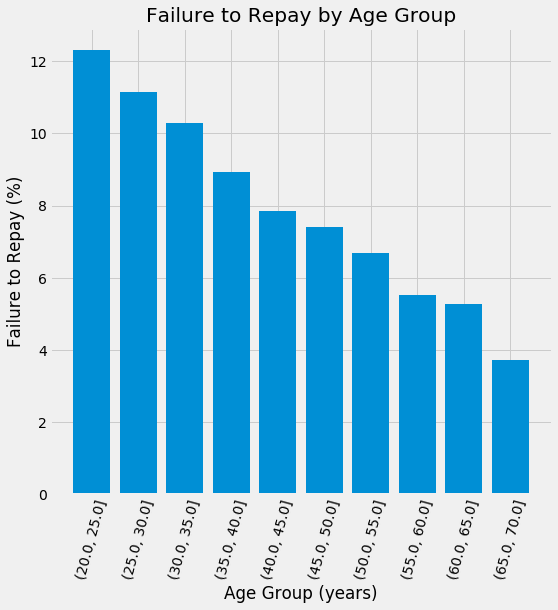

In [0]:
plt.figure(figsize = (8, 8))

# 구간별 평균 부도율
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# 레이블
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

- 한가지 특성에 대한 결과지만 유용하게 사용할 수 있다.
- 다른 변수와의 조합으로 결과는 달라질 수 있다.

### 외부 특성 (Exterior Sources)

- 다음의 세가지, 알 수 없는 외부 변수가 음의 상관관계가 크다 `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.

In [0]:
# 세가지 외부 변수의 상관관계
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


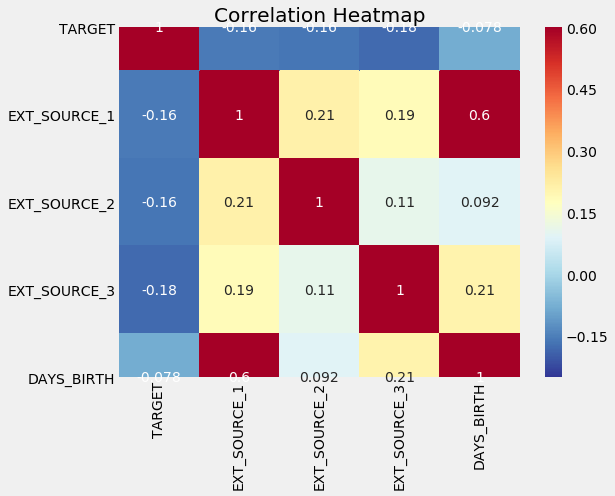

In [0]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

- 세가지 변수 `EXT_SOURCE` 모두 목적변수와 음의 관계이다.
- `DAYS_BIRTH`는 `EXT_SOURCE_1`와 양의 관계이다.
- 세 변수와 목적변수와의 관계를 보겠다.

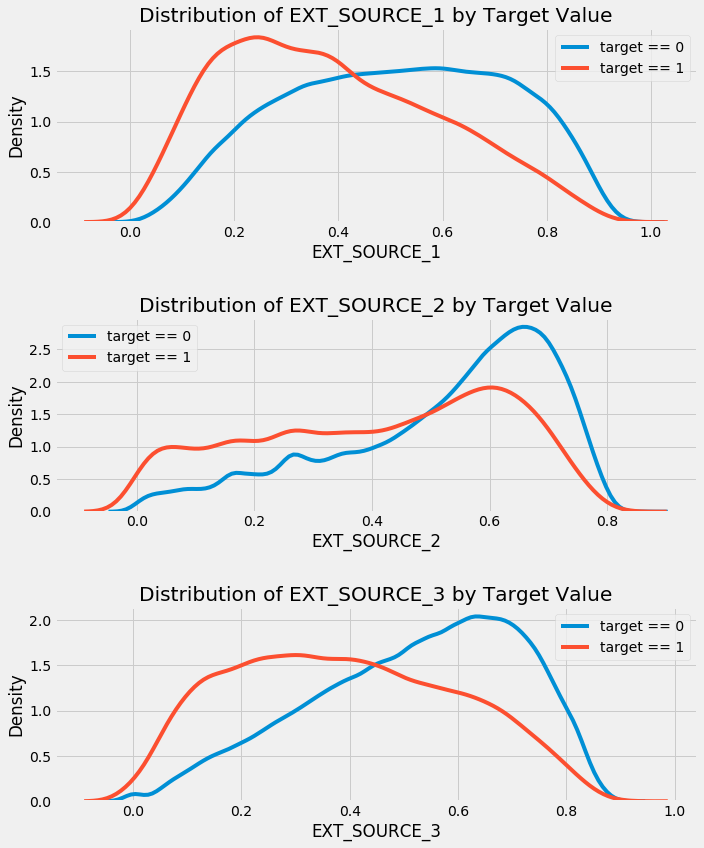

In [0]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # subplot 생성
    plt.subplot(3, 1, i + 1)
    # 상환 결과
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # 미상환 결과
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # 레이블
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

- `EXT_SOURCE_3`는 타겟 변수를 잘 설명하고 있다.

## Pairs Plot

- `EXT_SOURCE` 변수와 `DAYS_BIRTH` 변수의 [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) 을 보겠다.
- seaborn의 PairGrid 함수를 위쪽에, 히스토그램을 대각선에, 2D 커널 밀도함수와 상관계수를 아래에 그렸다.

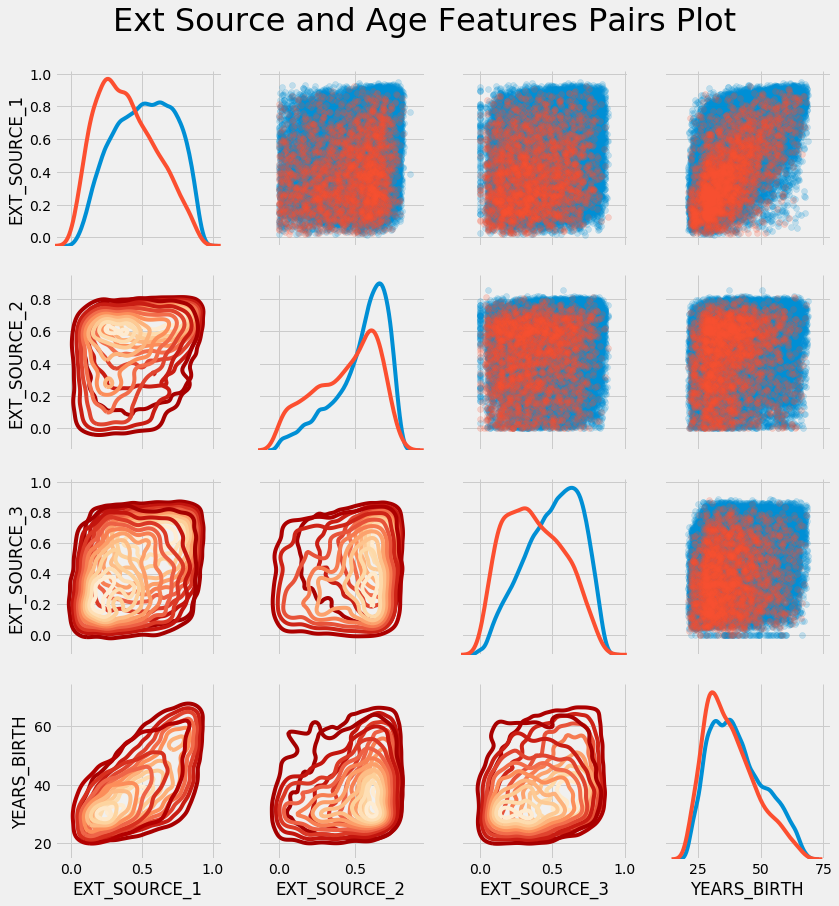

In [0]:
# 그림을 그리기 위해서 데이터 사본 생성
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# 연단위 나이 컬럼을 추가
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# 결측치를 제외하고, 처음 100000개의 샘플만 그린다
plot_data = plot_data.dropna().loc[:100000, :]

# 상관계수 구하기
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# pairgrid 객체 생성
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# 상단에 스캐터 플롯
grid.map_upper(plt.scatter, alpha = 0.2)

# 대각선에 히스토그램
grid.map_diag(sns.kdeplot)

# 하단에 밀도함수
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

- 붉은색은 미상환, 푸른색은 상환을 표시
- `EXT_SOURCE_1`와 `DAYS_BIRTH` (`YEARS_BIRTH`)는 양의 관계임을 알 수 있다.

# 데이터 전처리
- 모든 특성을 사용한다.
- 스케일링을 사용한다.

In [0]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# 타겟 제외
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# 특성 이름 리스트
features = list(train.columns)

# 테스트 데이터 사본
test = app_test.copy()

# 중위값으로 대체
imputer = Imputer(strategy = 'median')

# 스케일링
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit (훈련 데이터 사용)
imputer.fit(train)

# Transform
train = imputer.transform(train)
test = imputer.transform(app_test)

# 스케일링
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


## 훈련 데이터를 검증데이터로 나누어 사용

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, train_labels)


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 10, random_state = 50, verbose = 1, n_jobs = -1)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


0.9207055334425973

In [0]:
clf_y_pred = clf.predict(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


In [0]:
confusion_matrix(y_test, clf_y_pred)

array([[70734,   133],
       [ 5963,    48]])

In [0]:
confusion_matrix(y_test, clf_y_pred)

array([[70734,   133],
       [ 5963,    48]])

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


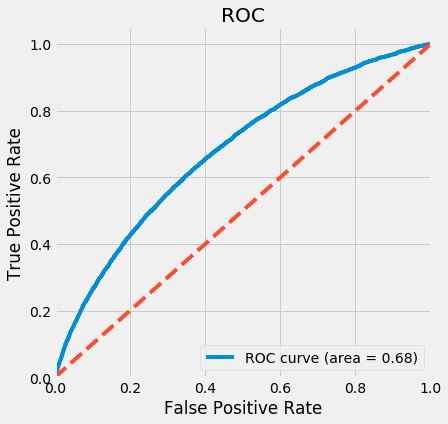

In [0]:
clf_scores = clf.predict_proba(x_test)[:, 1]
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [0]:
print(classification_report(y_test, clf_y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70867
           1       0.27      0.01      0.02      6011

    accuracy                           0.92     76878
   macro avg       0.59      0.50      0.49     76878
weighted avg       0.87      0.92      0.88     76878



In [0]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})


## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [0]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

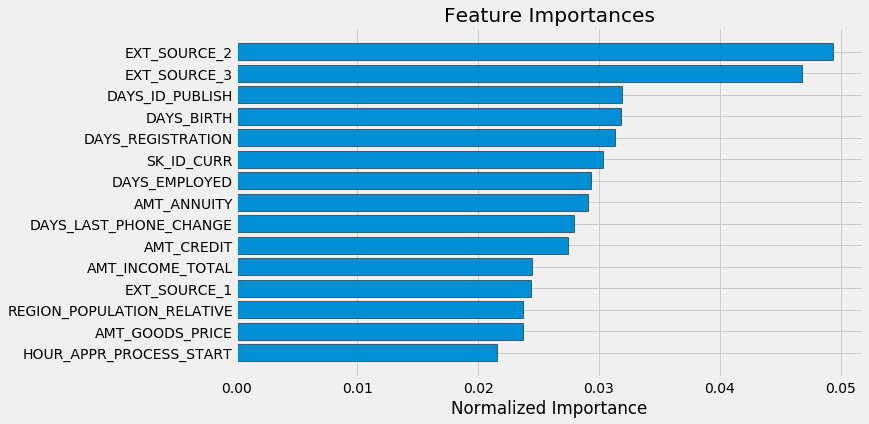

In [0]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 